## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

- A / B tests perorm when we have two hypotheses want to choose one of them 

- the null hypothesis which we assume is true before any collected data. after we collect the data we want to talk a decision about whether to reject or accept the null hypothesis and there are alternative hypothesis which we believe it is True 

- we can do these by different ways the simple one is confidence interval and the tricky one the p-value


<a id='probability'></a>
#### Part I - Probability

here we import the liabrary that we need for our task 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

here we will retrieve the 5 top row to see how our data looks like

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


How many rows do we have in our dataset?

In [3]:
df.shape[0]

294478

let's see how many unique user ?

In [4]:
df.user_id.nunique()

290584

what is the proportion for people converted (choose to pay in seek of the company after launch as new page)

In [5]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.groupby(df["group"])["landing_page"].value_counts()

group      landing_page
control    old_page        145274
           new_page          1928
treatment  new_page        145311
           old_page          1965
Name: landing_page, dtype: int64

In [7]:
1928 + 1965

3893

In [8]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

it seems there is no missing value in our dataset

In [9]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**

we need to handle this issue by drop these rows to avoid get unreliable insights 


In [10]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index , axis=0)

to check if we droped these rows correctly

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0


let's check again after we droped these row and assign it to new varaible how many unique user do we have

In [12]:
df2.user_id.nunique()

290584

to see if there is a duplicated user

In [13]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

to get information about these duplicated user

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


we need just unique user (each user represented just one time so we will remove one of duplicated user)

In [15]:
df2.drop(df2[df2.user_id.duplicated()].index , inplace = True)
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


the probability of an individual converting whether he is on old page or new page

In [16]:
df2.converted.mean()

0.11959708724499628

if the individaul was in control (before we do our experiment), the probability they converted is

In [17]:
df2.query('group =="control"')["converted"].mean()

0.1203863045004612

now when we run experiment we want to know about  the probability of individual who converted is

In [18]:
df2.query('group =="treatment"')["converted"].mean()

0.11880806551510564

the probability that an individual received the new page is?

In [19]:
df2.query('landing_page =="new_page"').count() / len(df2)

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

about half of our sample receive the new page

after we do these things actually it seems we don't have sufficient evidence as to the percentage for the old group which is 12% is greater than  11.8% (experimental group) and this is just a little different to decide our decision so we need to run A/B test 

the probability for converted in each group is approximately equal for each group even if there is a small different  this not consider as practically significant


the time frame should be consider for these experiment 

<a id='ab_test'></a>
### Part II - A/B Test

keep in mind we should do these experiment for enough time as to avoid theses kind of thing

- `Novelty effect` people who like anything new regardless is good enough or not
- `hange aversion` people who don't like change, Howver this change can bee good so we need to run our experiment for enough time to overcome such issue 

another issue we should consider cost-benefit analysis for example may your new page attract more customer to convert but may this cost you more than revenue that you will get from it





we  want to supposed  that the old page is better (we assume this True before collect any data) unless the new page proves to be definitely better (We hope to be this True) at a Type I error rate of 5% which is called alpha and this is the worset type of error

$$ H_0: P_{new} - P_{old} <= 0  $$
$$ H_1: P_{new} - P_{old} > 0 $$

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>



the **convert rate** for $p_{new}$ under the null

In [30]:
p_new = df2["converted"].mean()
p_new

0.11959708724499628

 the **convert rate** for $p_{old}$ under the null? <br><br>

In [31]:
p_old = df2["converted"].mean()
p_old

0.11959708724499628

$n_{new}$ >> number of people in Treatment group (experimental)

In [27]:
n_new = (df2.group == "treatment").sum()
n_new

145310

 $n_{old}$ number of people in old group (before run experiment)

In [28]:
n_old = (df2.group == "control").sum()
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = df2[(df2.group == "treatment")]["converted"].mean()
new_page_converted

0.11880806551510564

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = df2[(df2.group == "control")]["converted"].mean()
old_page_converted

0.1203863045004612

$p_{new}$ - $p_{old}$  if these greater than Zero means the proprtion that lead people converted in new page is higher than the old page 

In [43]:
new_page_converted - old_page_converted  

-0.0015782389853555567

**the difference is very small that we lead us consider the practical significance which may we should consider a diiferent aspect may new page is better if we include the cost versus benefit** 

**in other words accept or reject the null hypothsis dosen't make a senece**

simulate 10,000 $p_{new}$ - $p_{old}$ 
to create bootstrap distibution to get bootsttraping normal distribution in order to wether we will reject or accept the null hypothesis at Type 1 error 5%

In [32]:
new_converted_simulation = np.random.binomial(n_new, new_page_converted , 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, old_page_converted, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs

array([-0.00267946, -0.00255565, -0.00028426, ..., -0.00316824,
       -0.00161954, -0.00204625])

Plot a histogram of the **p_diffs**. 
it seems the mean is equall to two -0.002 approximatly zero so we will stick with null hypothesis

(array([  30.,  130.,  549., 1530., 2585., 2637., 1635.,  720.,  159.,
          25.]),
 array([-5.87991351e-03, -5.02921420e-03, -4.17851489e-03, -3.32781559e-03,
        -2.47711628e-03, -1.62641697e-03, -7.75717667e-04,  7.49816402e-05,
         9.25680947e-04,  1.77638025e-03,  2.62707956e-03]),
 <a list of 10 Patch objects>)

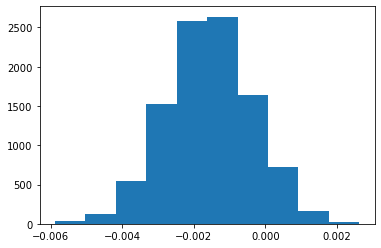

In [33]:
#  sampling distribution
plt.hist(p_diffs)


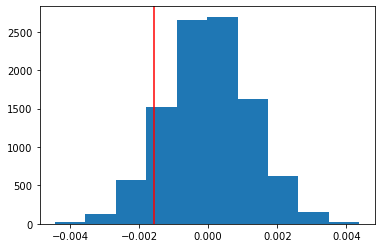

In [35]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
lower_bound = p_diffs.mean()

plt.hist(null_vals)
plt.axvline(lower_bound , color="red")

proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [41]:
(lower_bound < null_vals ).mean()

0.9002

__it is called `P-value` = 0.9002 and when it is smaller than `Type I error rate` we accept the null hypothsis so in this case__
$$ p_value > 0.05 $$ >> accept the null hypothsis 


__why this not cnosider as  practical significance?__

- so i prefere  to keep the null hyothsis 


acctualy bootstrap take much time to compute these p-value let's try doing these but using ztest which  is more faster than bootstrap technique

In [37]:
import statsmodels.api as sm

convert_old = df2[(df2.group == "control")]["converted"]
convert_new = df2[(df2.group == "treatment")]["converted"]
n_old = convert_old.count()
n_new = convert_new.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [40]:
from statsmodels.stats.proportion import proportions_ztest
# stats , pvalue = proportions_ztest(n_old, n_new  ,  convert_new.sum() - convert_old.sum()   , "larger")
zscore, pval = proportions_ztest([convert_new.sum() ,convert_old.sum()], [n_new,n_old], alternative='larger')

zscore, pval

(-1.3109241984234394, 0.9050583127590245)

 p-value looks like as we computed from bootstrapping distribution which lead to accept the null hypothsis but  new_page_converted - old_page_converted is a very small   difference  in other words accept or reject the null hypothsis dosen't make a senece

<a id='regression'></a>
### Part III - A regression approach


another way to perform these test is regression approach  and we will use 

> __Logistic regression model as we have just to outcome (conversion or no conversion)__

we will  use **statsmodels** to fit the regression model  to see if there is a significant difference in conversion based on which page a customer receives. 
first  we need to create a column for the intercept
create a dummy variable column for which page each user received.
Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [100]:
df2["intercept"] = 1
df2 = df2.join(pd.get_dummies(df2["group"]))
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [101]:
df2.rename(columns = {"treatment" : "ab_page"} , inplace=True)

Useing **statsmodels** to import your regression model.  Instantiate the model, and fit the modelto predict whether or not an individual converts.

In [109]:
logistic_regression = sm.Logit(df2["converted"] , df2[["intercept" , "ab_page"]]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


the summary of  model 

In [110]:
logistic_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:37:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

> __p-value asscociated with ab_page = `0.0150`
here we put the droped column as a baseline whice mean we compare we compare ab_page(new_page) comparing to the droped column (old_page)__

 Are there any disadvantages to adding additional terms into your regression model?

> __In Multi regression model x-variables just only realted to y variable and we assume there is no relationship between x-variable to another x-variable__

_How you can overcome this issue?_
> __so we will graph the relationship between your x- variable to
             make sure there is no relationship betwwen two indepentant variable if you see this kind or
              relation then your model is incorrect and in this cause we can't use Multi regression mode__
              
> __another way to do that using VIF (Variance inflation factor) if this indicator large than (>) 10
                then we should exclude these x-variables from our model otherwise this will be unreliable model (inaccurate model)__
                
                
**_Multi regression is a good idea when there is no relationship between x-variable ang give you (R greater than R generated from simple linear regression)_**

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives.

In [111]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [112]:
### Create the necessary dummy variables
df_new["intercept"] = 1 
df_new[["CA" , "UK" , "US"]] = pd.get_dummies(df_new["country"])

In [113]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


we would now like to look at an interaction between page and country to see if there significant effects on conversion.  

In [114]:
df_new["Page&CA"] = df_new["CA"] * df_new["ab_page"]
df_new["Page&UK"] = df_new["UK"] * df_new["ab_page"]
df_new["Page&US"] = df_new["US"] * df_new["ab_page"]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US,Page&CA,Page&UK,Page&US
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1,0


In [118]:
### Fit Your Linear Model And Obtain the Results
## when we do interaction between two xvariable we should include the interaction and the variable without interaction
sm.Logit(df_new["converted"] , df_new[["intercept" , "ab_page" , "CA" , "UK" , "Page&CA" , "Page&UK"]]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 16 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        20:49:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
Page&CA       -0.0469      0.054     -0.872      0.383      -0.152       0.059
Page&UK        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [1]:
# np.exp(variable) if we want to interpret this result  
# 1/np.exp(variable) to consider the opposit of affect here it is better to use this for your audiance


Does it appear that country had an impact on conversion? 
- if we look to the p value which is grater than 0.05 which say the coutry dosen't have impact on conversion 

another way to consider this issue but i am not sure about it it just intiuative

No after we add the conutry into our account the Pseudo R-squ decreased from 8.077e-06 to 3.482e-05
which make more weak relation (if this r-square that we have study in the class rom )



<a id='conclusions'></a>
## Conclusions

- don't reject the null hypothesis according to the reason that we have mentioned